In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from snowflake.connector.pandas_tools import write_pandas
from sqlalchemy import create_engine
import snowflake.connector
from plottable import ColDef, Table
from plottable.plots import image
from plottable.cmap import centered_cmap
from plottable.font import contrasting_font_color
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import io

from PIL import Image, ImageFilter
import requests
from io import BytesIO
import urllib
from urllib.request import urlopen
import base64

d:\Users\ksbha\miniconda3\envs\footy\Lib\site-packages\snowflake\connector\options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (14.0.2), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(
Failed to import ArrowResult. No Apache Arrow result set format can be used. ImportError: DLL load failed while importing arrow_iterator: The specified procedure could not be found.


In [2]:
import snowflake.connector

In [3]:
## Set options to view all columns
pd.set_option('display.max_columns', None)

In [4]:
SNOWFLAKE_USER = 'karan14'
SNOWFLAKE_PASSWORD = 'Snowfl@key0014'
SNOWFLAKE_ACCOUNT = 'lv65293.ca-central-1.aws'
SNOWFLAKE_WAREHOUSE = 'COMPUTE_WH'
SNOWFLAKE_DATABASE = 'GEGENSTATS'
SNOWFLAKE_SCHEMA = 'TABLES'

In [5]:
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
)

In [6]:
cursor = conn.cursor()

In [7]:
cursor.execute('SELECT * FROM TEAMS')
team_rows = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
team_names = pd.DataFrame(team_rows, columns=column_names)

In [8]:
cursor.execute('SELECT * FROM TEAM_ATTACKING_STATS')
attacking_rows = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
team_attacking = pd.DataFrame(attacking_rows, columns=column_names)

In [9]:
cursor.execute('SELECT * FROM TEAM_DEFENDING_STATS')
defending_rows = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
team_defending = pd.DataFrame(defending_rows, columns=column_names)

In [10]:
cursor.execute('SELECT * FROM TEAM_STANDARD_STATS')
standard_rows = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
team_standard = pd.DataFrame(standard_rows, columns=column_names)

In [11]:
cursor.execute('SELECT * FROM COMPETITIONS')
competition_rows = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
df_competitions = pd.DataFrame(competition_rows, columns=column_names)

In [12]:
team_standard = team_standard.merge(df_competitions[['COMPETITION','COMPETITION_ACRONYM','SEASON']], on=['COMPETITION','SEASON'], how='left')
team_attacking = team_attacking.merge(df_competitions[['COMPETITION','COMPETITION_ACRONYM','SEASON']], on=['COMPETITION','SEASON'], how='left')
team_defending = team_defending.merge(df_competitions[['COMPETITION','COMPETITION_ACRONYM','SEASON']], on=['COMPETITION','SEASON'], how='left')

In [13]:
df_table = team_standard[['TEAM_FBREF_ID', 'SEASON','COMPETITION_ACRONYM', 'TEAM_PTS', 'TEAM_XPTS']]

In [14]:
df_table = df_table.merge(team_names, how='left', on='TEAM_FBREF_ID')

In [15]:
df_table = df_table.merge(team_attacking[['TEAM_FBREF_ID', 'SEASON','COMPETITION_ACRONYM','GOALS_SCORED', 'XG']], 
                          on=['TEAM_FBREF_ID', 'COMPETITION_ACRONYM','SEASON'])

In [16]:
df_table = df_table.merge(team_defending[['TEAM_FBREF_ID', 'SEASON', 'COMPETITION_ACRONYM','GOALS_CONCEDED', 'XG_AGAINST']], 
                          on=['TEAM_FBREF_ID', 'COMPETITION_ACRONYM','SEASON'])

In [17]:
df_table["GOAL_DIFFERENCE"] = df_table["GOALS_SCORED"] - df_table["GOALS_CONCEDED"]

In [18]:
## Create emply datframe called PTS_table with columns 'TEAM_NAME','TEAM_PTS', 'GOAL_DIFFERENCE','GOALS_SCORED','GOALS_CONCEDED', 'index'"Power BI"
base64_table = pd.DataFrame(columns=['COMPETITION_ACRONYM', 'SEASON', 'TABLE_BASE64'])

In [19]:
options = df_table[['COMPETITION_ACRONYM', 'SEASON']].drop_duplicates().reset_index(drop=True)

In [20]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) \
           Chrome/58.0.3029.110 Safari/537.3'}

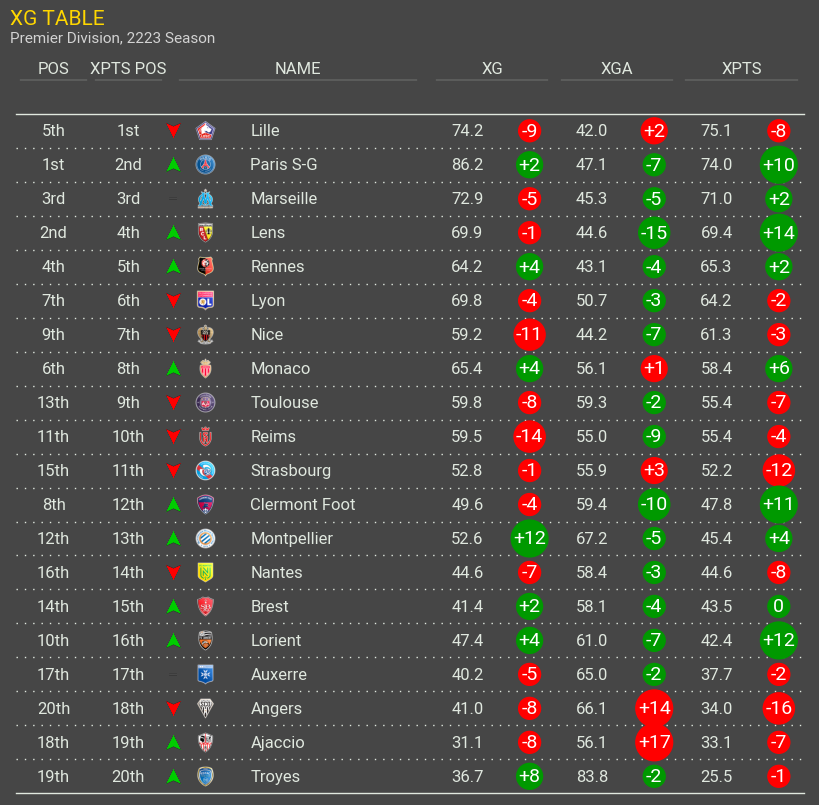

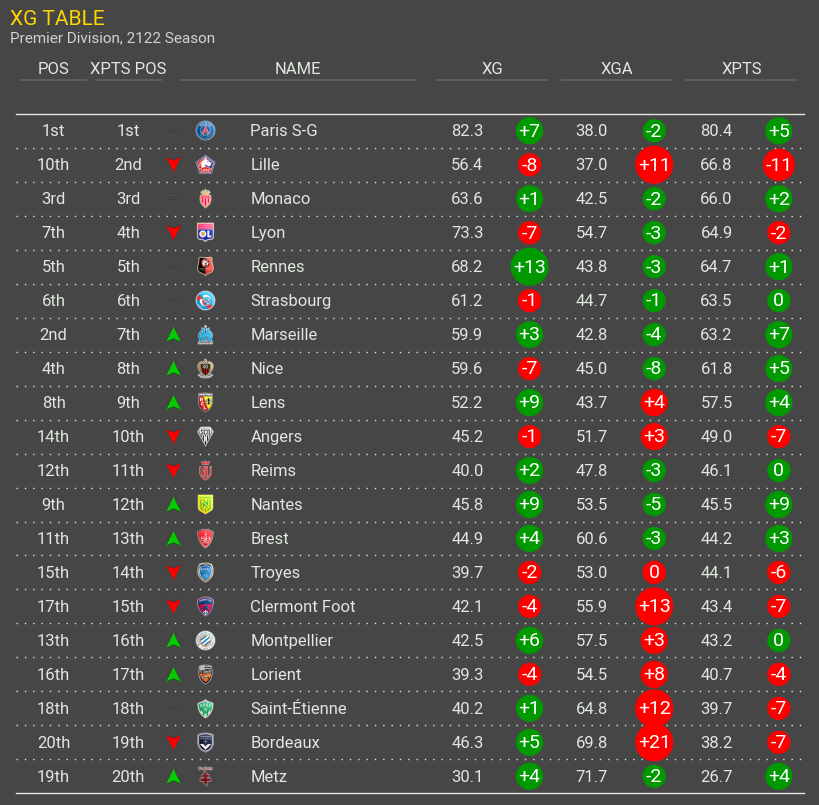

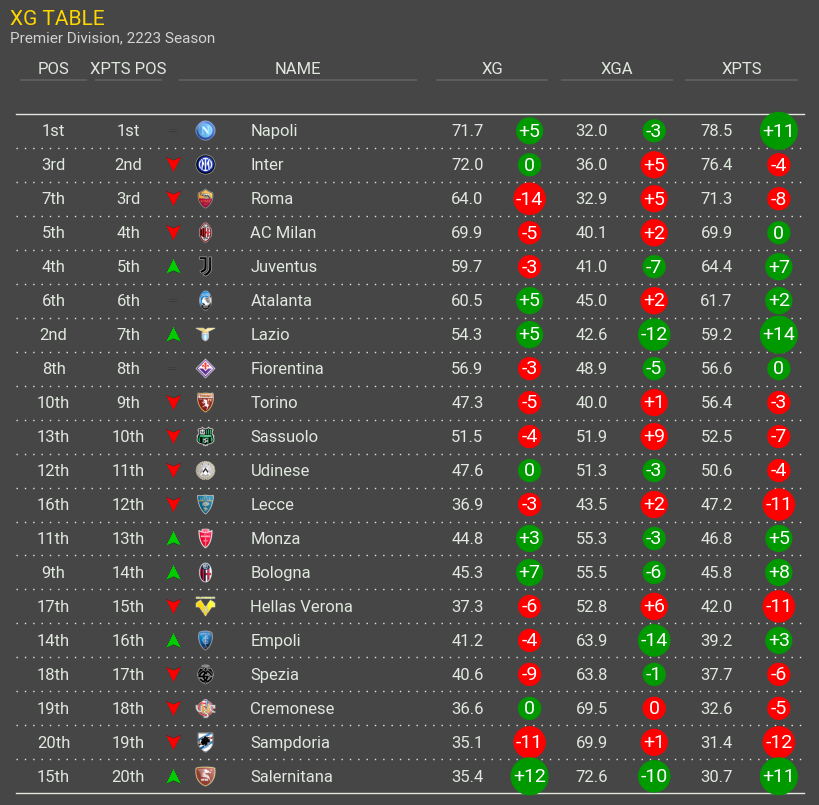

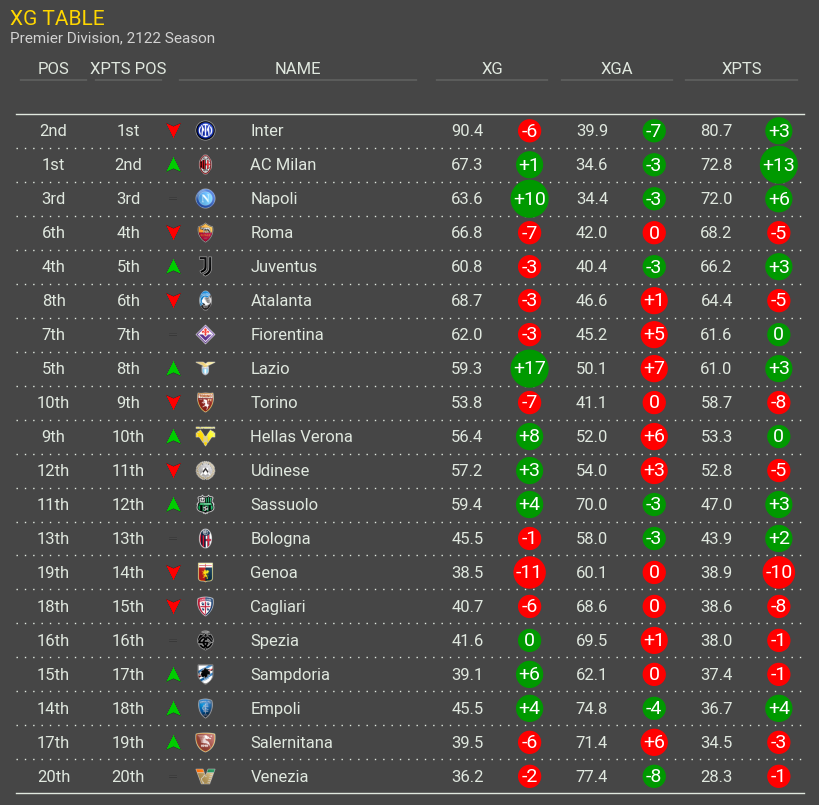

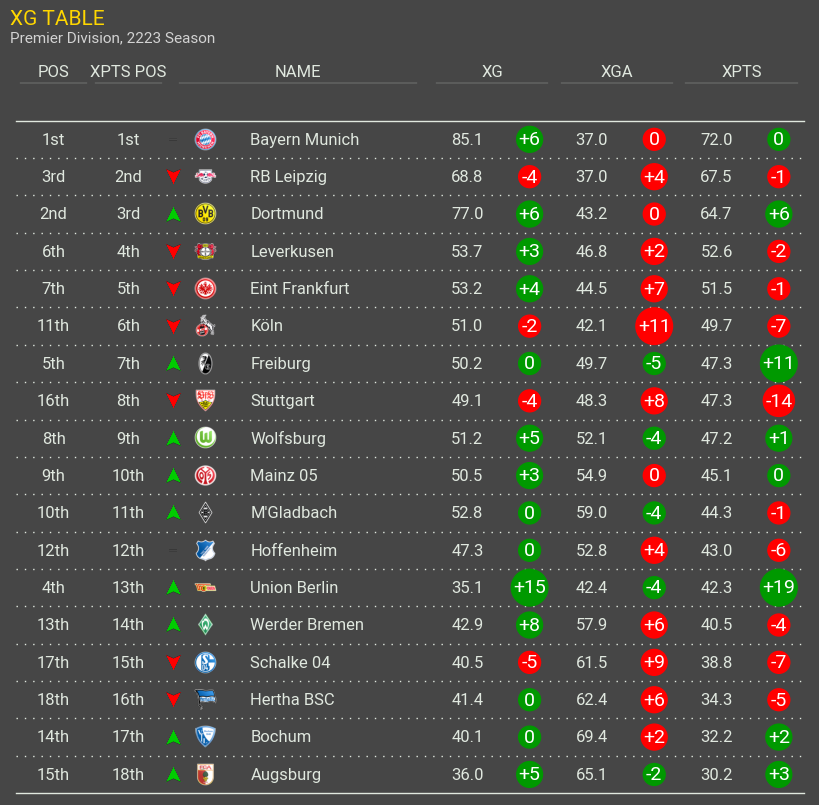

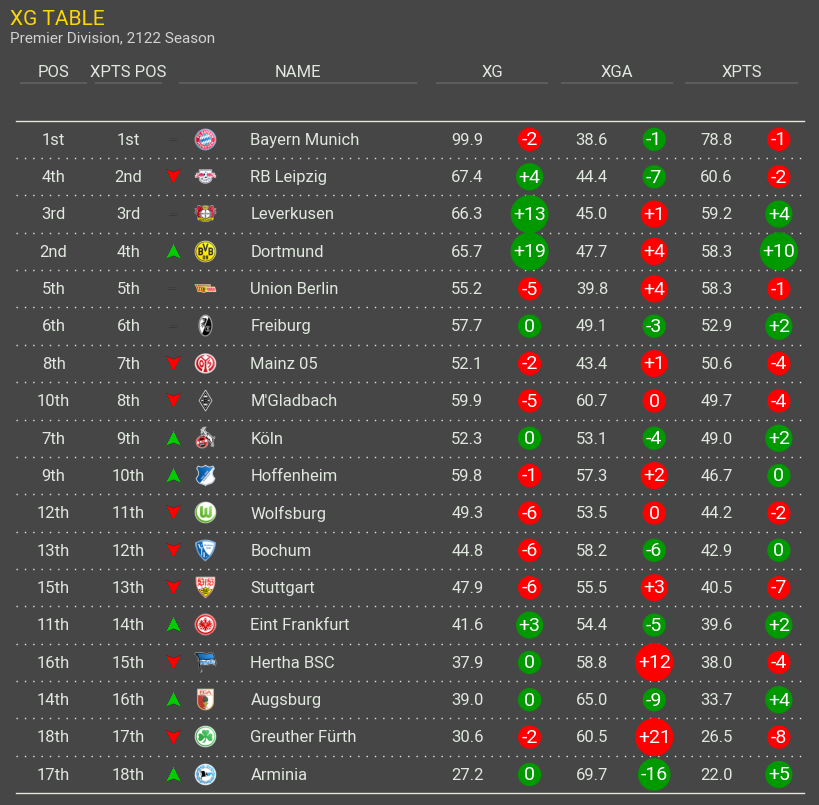

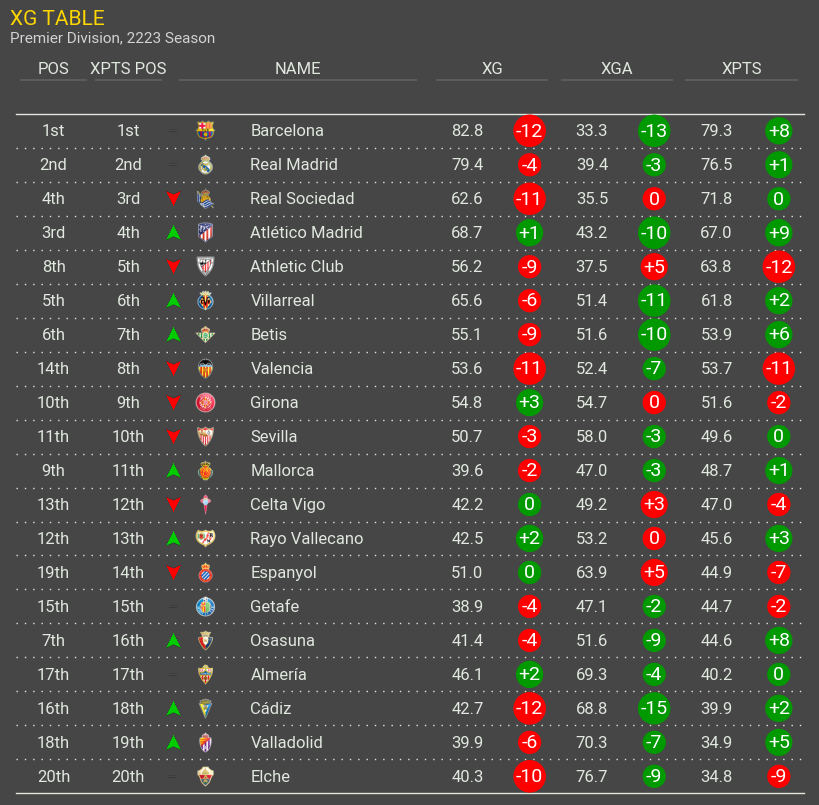

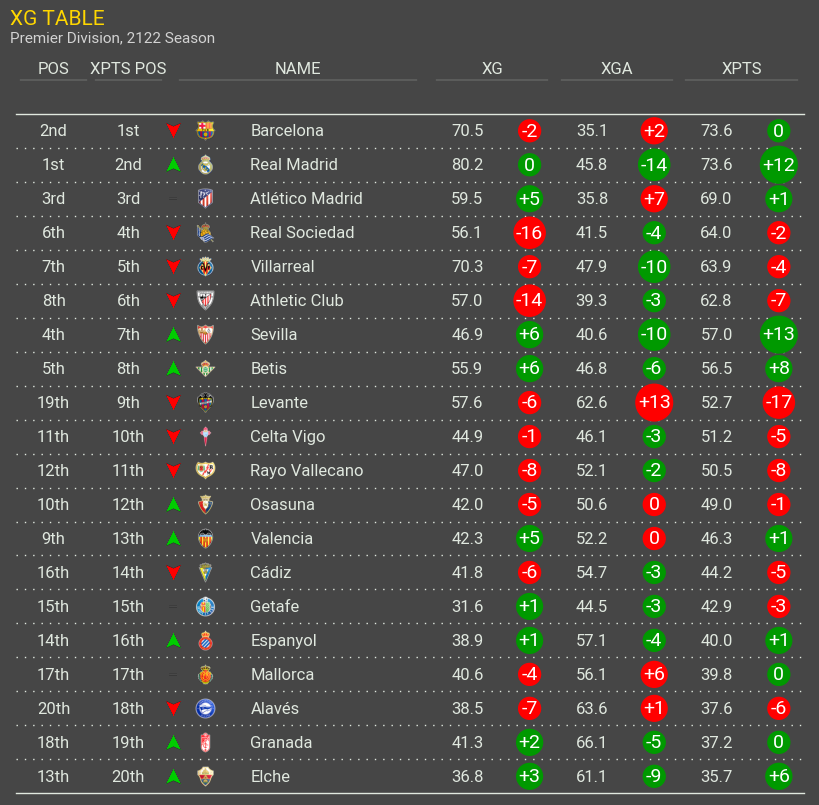

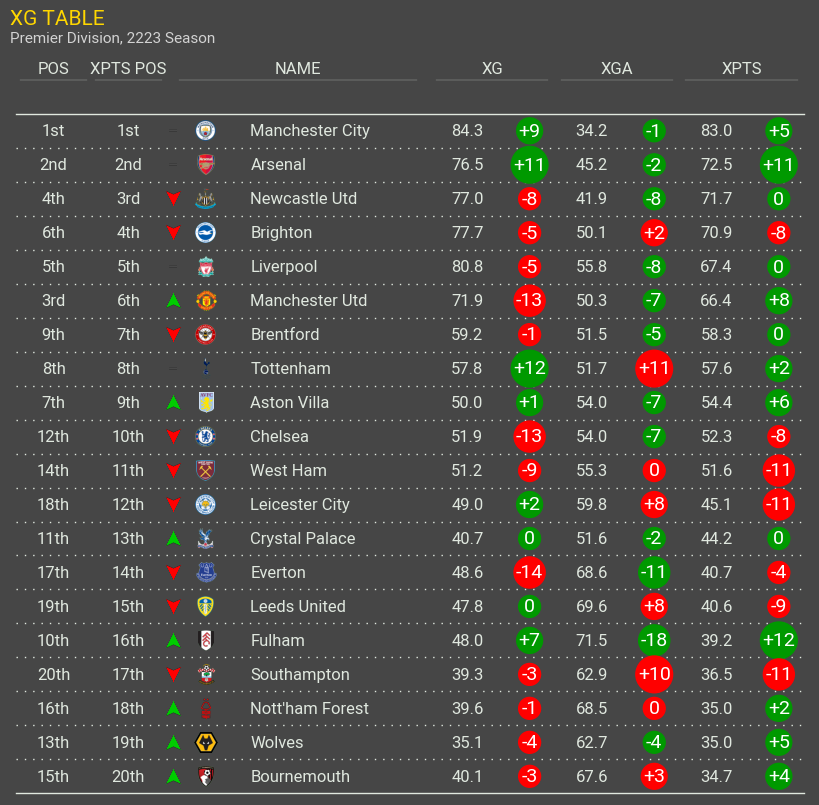

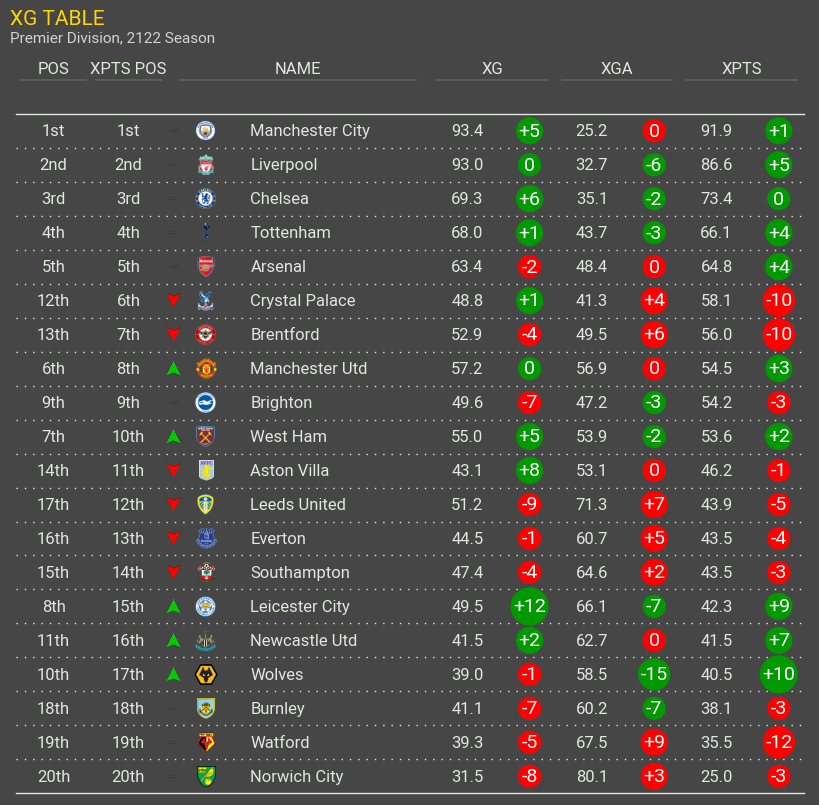

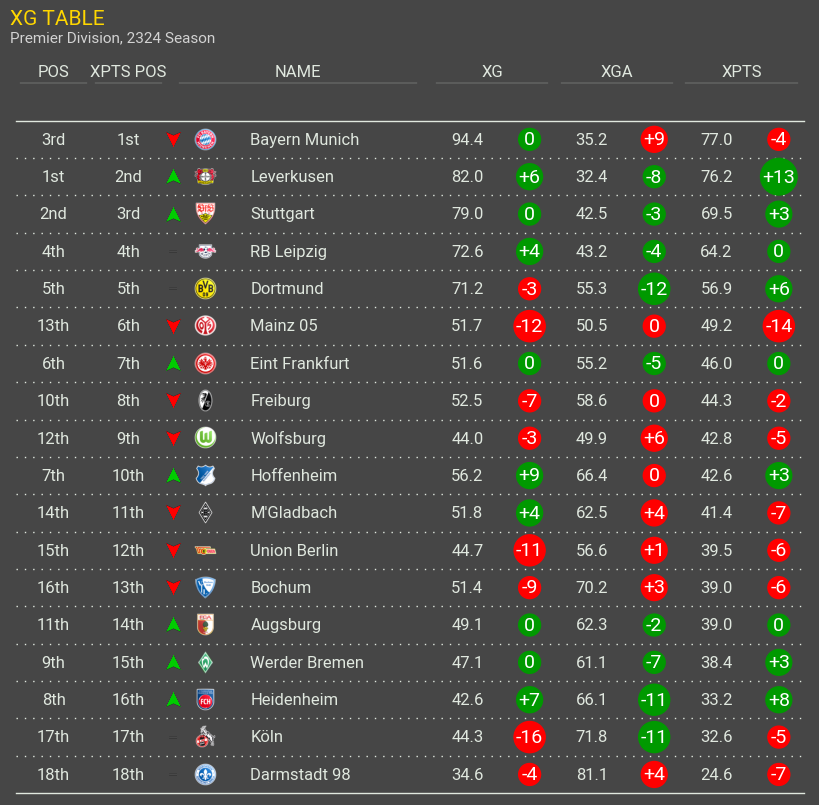

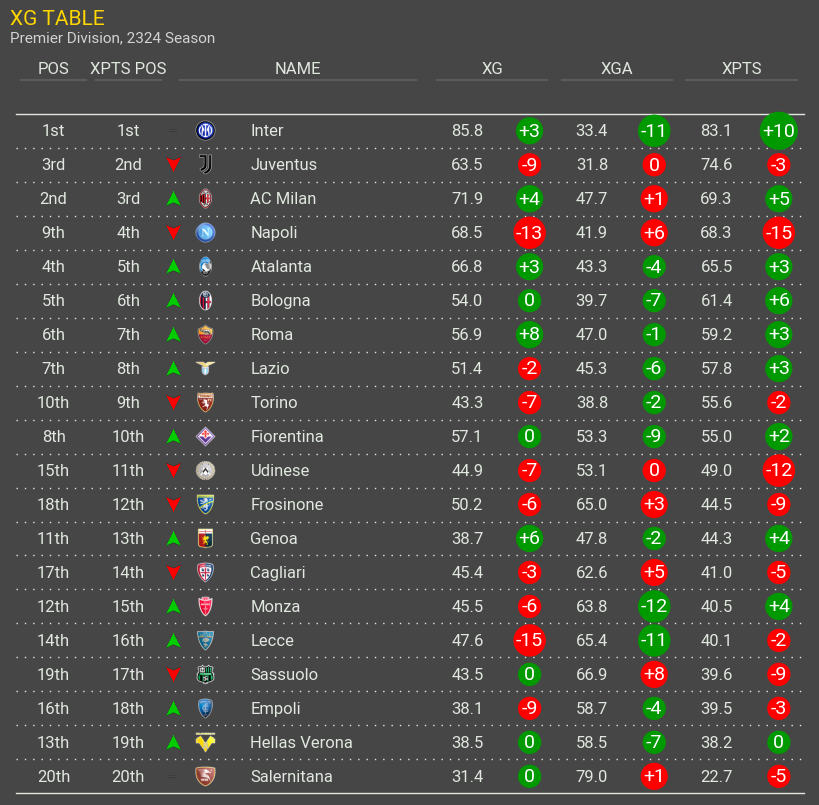

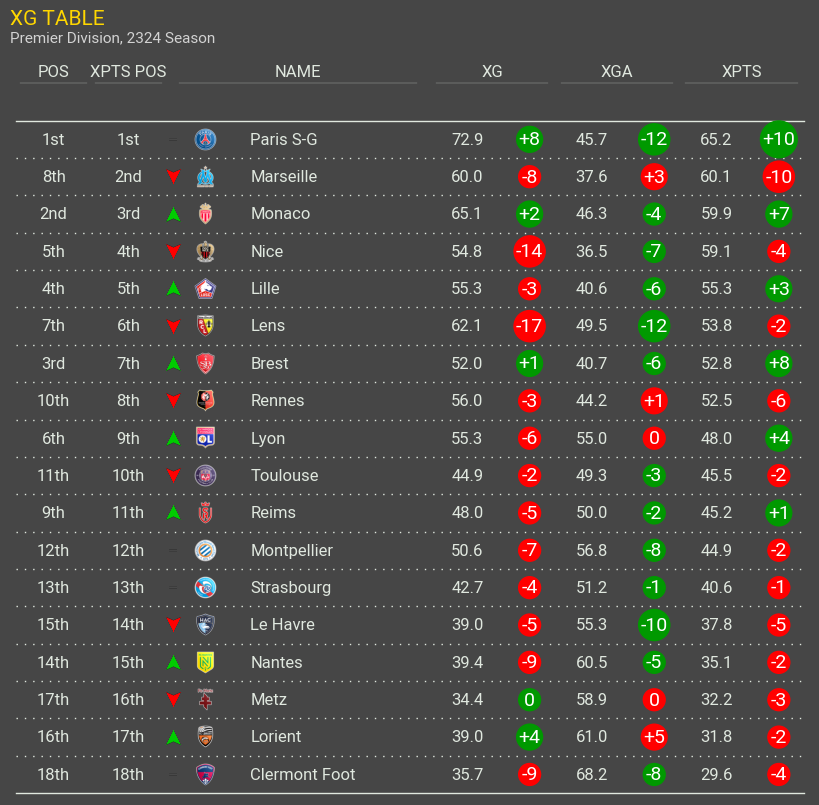

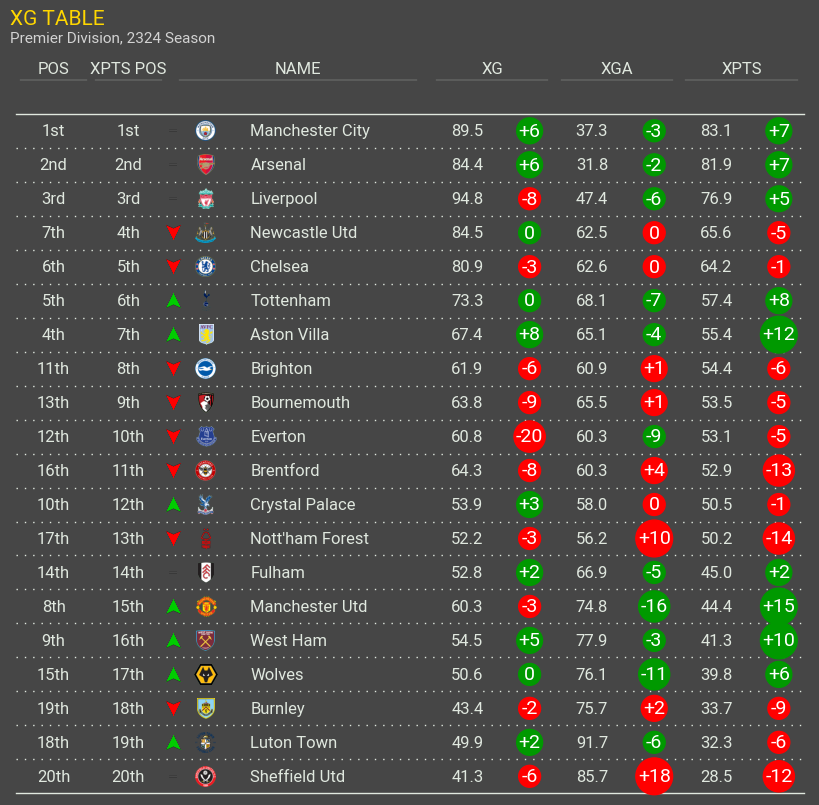

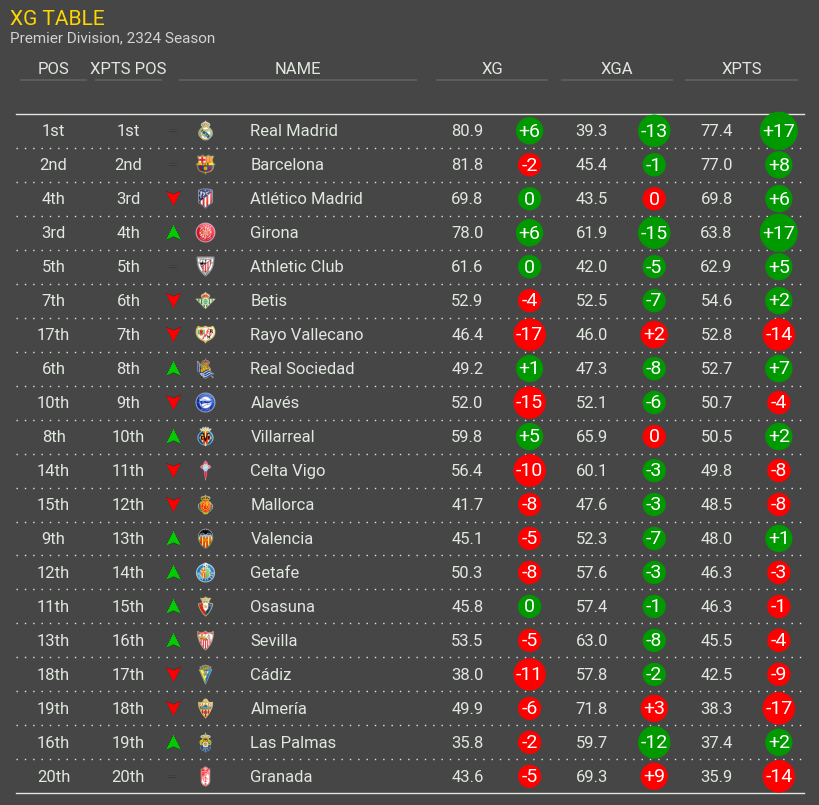

In [21]:
colors_pos = [(1, 0, 0), (0, 0.6, 0)]  # Red to Green
colors_neg = [(0, 0.6, 0), (1, 0, 0)]  # Green to Red
n_bins = 2 # Discretizes the interpolation into bins
cmap_name = 'custom_red_green'
cm_pos = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors_pos, N=n_bins)
cm_neg = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors_neg, N=n_bins)


def plus_sign_formatter(value):
    return f"+{value:.0f}" if value > 0 else f"{value:.0f}"

listos = []

for index, row in options.iterrows():
    df_filtered = df_table[df_table['COMPETITION_ACRONYM'] == row['COMPETITION_ACRONYM']]
    df_filtered = df_filtered[df_filtered['SEASON'] == row['SEASON']]

    PTS_table = df_filtered[['TEAM_NAME','TEAM_PTS', 'GOAL_DIFFERENCE','GOALS_SCORED','GOALS_CONCEDED']].sort_values(['TEAM_PTS', 
                    'GOAL_DIFFERENCE','GOALS_SCORED','GOALS_CONCEDED'], ascending=False).reset_index(drop=True).reset_index()
    
    PTS_table.rename(columns={'index':'POS_NUM'}, inplace=True)
    PTS_table.POS_NUM += 1

    ## Change POS_NUM colun in PTS_table from 1,2,3 to 1st, 2nd,3rd etc/
    def ordinal(n):
        return "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

    PTS_table['POS'] = PTS_table['POS_NUM'].apply(ordinal)

    XPTS_table = df_filtered[['TEAM_NAME','TEAM_XPTS', 'GOAL_DIFFERENCE','GOALS_SCORED'
          ,'GOALS_CONCEDED']].sort_values(['TEAM_XPTS', 'GOAL_DIFFERENCE','GOALS_SCORED','GOALS_CONCEDED'],
                                          ascending=False).reset_index(drop=True).reset_index()
    
    XPTS_table.rename(columns={'index':'XPTS POS_NUM'}, inplace=True)
    XPTS_table['XPTS POS_NUM'] += 1

    XPTS_table['XPTS POS'] = XPTS_table['XPTS POS_NUM'].apply(ordinal)

    PTS_XPTS_table = XPTS_table.merge(PTS_table, how='left', on=['TEAM_NAME','GOAL_DIFFERENCE','GOALS_SCORED','GOALS_CONCEDED'])

    PTS_XPTS_table = PTS_XPTS_table[['TEAM_NAME','XPTS POS','XPTS POS_NUM','POS','POS_NUM']]

    df_filtered = df_filtered.merge(PTS_XPTS_table, how='left', on='TEAM_NAME')

    df_filtered.rename(columns={'TEAM_LOGO_URL':'TEAM_LOGO'}, inplace=True)

    import warnings
    warnings.filterwarnings("ignore")

    fin_table = df_filtered[['POS','POS_NUM','TEAM_LOGO','XPTS POS','XPTS POS_NUM','TEAM_NAME','XG','GOALS_SCORED','XG_AGAINST',
            'GOALS_CONCEDED','TEAM_PTS','TEAM_XPTS']].sort_values('XPTS POS_NUM')
    fin_table['POS_NUM_DIFF'] = fin_table.apply(lambda row: 'https://i.imgur.com/AACUEGy.png' if row['POS_NUM'] == row['XPTS POS_NUM'] else \
                                                'https://i.imgur.com/5sTTYXm.png' if row['POS_NUM'] < row['XPTS POS_NUM'] else 'https://i.imgur.com/dGsmsnm.png', axis=1)
    fin_table['XG_DIFF'] = fin_table['GOALS_SCORED']-fin_table['XG']
    fin_table['XGA_DIFF'] = fin_table['GOALS_CONCEDED']-fin_table['XG_AGAINST']
    fin_table['XPTS_DIFF'] = fin_table['TEAM_PTS']-fin_table['TEAM_XPTS']
    fin_table = fin_table[['POS','XPTS POS','POS_NUM_DIFF','TEAM_LOGO','TEAM_NAME','XG','XG_DIFF',
            'XG_AGAINST','XGA_DIFF','TEAM_XPTS','XPTS_DIFF']]
    fin_table['XG_DIFF'] = fin_table['XG_DIFF'].astype(int)
    fin_table['XGA_DIFF'] = fin_table['XGA_DIFF'].astype(int)
    fin_table['XPTS_DIFF'] = fin_table['XPTS_DIFF'].astype(int)

    fin_table = fin_table.set_index(['POS'])

    team_name_cols = ['TEAM_LOGO','TEAM_NAME']
    xG_cols = ['XG','XG_DIFF']
    xGA_cols = ['XG_AGAINST','XGA_DIFF']
    xPTS_cols = ['TEAM_XPTS','XPTS_DIFF']

    fin_table['TEAM_LOGO'] = fin_table['TEAM_LOGO'].apply(lambda x: (io.BytesIO(urllib.request.urlopen(urllib.request.Request(x, headers=headers)).read())))
    fin_table['POS_NUM_DIFF'] = fin_table['POS_NUM_DIFF'].apply(lambda x: (io.BytesIO(urllib.request.urlopen(urllib.request.Request(x, headers=headers)).read())))

    plt.rcParams["font.family"] = ["Roboto"]
    plt.rcParams["savefig.bbox"] = "tight"
    plt.rcParams["text.color"] = "#e0e8df"

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_title('XG TABLE', fontsize=15, fontweight='bold', color='gold', 
                loc='left',pad=15)

    subtitle_y_position = 1.005  # Adjust this value as needed
    ax.text(0.0, subtitle_y_position, f"Premier Division, {row['SEASON']} Season", 
            fontsize=11, color='lightgray', transform=ax.transAxes)

    fig.set_facecolor("#464646")
    ax.set_facecolor("#464646")

    fig.subplots_adjust(top=0.85, bottom=0.1, left=0.1, right=0.9)

    col_defs = (
        [
        ColDef(name="POS", title="", group="POS",textprops={"ha": "center", "weight": "bold"}, width=0.3),
        ColDef(name="XPTS POS", title="", group="XPTS POS", textprops={"ha": "center", "weight": "bold"}, width=0.3),
        ColDef(name="POS_NUM_DIFF", title="", group="NAME",textprops={"ha": "center"}, width=0.06,plot_fn=image),
        ColDef(name="TEAM_LOGO", title="", group="NAME",textprops={"ha": "center"}, width=0.2, plot_fn=image),
        ColDef(name="TEAM_NAME", title="",group="NAME",textprops={"ha": "left"}, width=0.8),
        ColDef(name="XG", title="", group="XG",textprops={"ha": "center"}, formatter="{:.1f}", width=0.3),
        ColDef(name="XG_DIFF", title="", group="XG", textprops={"ha": "center","fontsize": 14,"fontweight": "bold","bbox": {"boxstyle": "circle,pad=0.1"}}, 
            formatter=plus_sign_formatter, width=0.2, cmap=centered_cmap(fin_table["XG_DIFF"], cmap=cm_pos, center=0)),
        ColDef(name="XG_AGAINST", title="", group="XGA",textprops={"ha": "center",}, formatter="{:.1f}", width=0.3),
        ColDef(name="XGA_DIFF", title="", group="XGA",textprops={"ha": "center","fontsize": 14,"fontweight": "bold","bbox": {"boxstyle": "circle,pad=0.1"}}, 
            width=0.2, formatter=plus_sign_formatter,cmap=centered_cmap(fin_table["XG_DIFF"], cmap=cm_neg, center=0)),
        ColDef(name="TEAM_XPTS", title="", group="XPTS",textprops={"ha": "center"}, formatter="{:.1f}", width=0.3),
        ColDef(name="XPTS_DIFF", title="", group="XPTS",textprops={"ha": "center","fontsize": 14,"fontweight": "bold","bbox": {"boxstyle": "circle,pad=0.1"}}, 
            width=0.2, formatter=plus_sign_formatter,cmap=centered_cmap(fin_table["XG_DIFF"], cmap=cm_pos, center=0)),
        ]
    )

    table = Table(
        fin_table,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        textprops={"fontsize": 12},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider={"linewidth": 1, "linestyle": (0, (1, 5))},
    )

    table.autoset_fontcolors(colnames=["XG_DIFF", "XGA_DIFF", "XPTS_DIFF"])

    buf = io.BytesIO()

    # Save the figure to the buffer
    fig.savefig(buf, format='png')

    # Seek to the start of the buffer
    buf.seek(0)

    encoded_data = base64.b64encode(buf.getvalue()).decode()

    # listos.append(encoded_data)

    new_row = {
        'COMPETITION_ACRONYM': row['COMPETITION_ACRONYM'],
        'SEASON': row['SEASON'],
        'TABLE_BASE64': encoded_data
    }

    base64_table = pd.concat([base64_table, pd.DataFrame([[row['COMPETITION_ACRONYM'], row['SEASON'], encoded_data]], 
                                      columns=['COMPETITION_ACRONYM','SEASON','TABLE_BASE64'])])


In [22]:
binary_data = base64.b64decode(base64_table[(base64_table['COMPETITION_ACRONYM'] == 'EPL') & 
                                            (base64_table['SEASON'] == 2122)]['TABLE_BASE64'].iloc[0])
image_buffer = io.BytesIO(binary_data)
image = Image.open(image_buffer)
image.show()

### Update to the table to Snowflake

In [23]:
# SNOWFLAKE_USER = 'kbharaj3'
# SNOWFLAKE_PASSWORD = 'Snowfl@key0014'
# SNOWFLAKE_ACCOUNT = 'qx25653.ca-central-1.aws'
# SNOWFLAKE_WAREHOUSE = 'FOOTY_STORE'
# SNOWFLAKE_DATABASE = 'GEGENSTATS'
SNOWFLAKE_SCHEMA = 'RADAR_CHARTS'

In [24]:
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
    )

In [25]:
cur = conn.cursor()
# cur.execute(f"USE WAREHOUSE {SNOWFLAKE_WAREHOUSE}")

In [26]:
# create_schema_sql = f"CREATE SCHEMA IF NOT EXISTS {SNOWFLAKE_SCHEMA}"
# cur.execute(create_schema_sql)

In [27]:
create_table_query = """
CREATE TABLE IF NOT EXISTS XPTS_TABLE (
    COMPETITION_ACRONYM VARCHAR(255),
    SEASON INT,
    TABLE_IMAGE VARIANT,
    PRIMARY KEY (COMPETITION_ACRONYM, SEASON)
);
"""

In [28]:
cur.execute(create_table_query)

In [29]:
def insert_to_snowflake_DB(primary_keys, table_name, dataframe, replace=False):
    if replace:
        cur.execute(f"TRUNCATE TABLE {table_name}")
        success, nchunks, nrows, _ = write_pandas(conn, dataframe, table_name)
    else:
        cur.execute(f"SELECT {', '.join(primary_keys)} FROM {table_name}")
        existing_ids = cur.fetchall()
        existing_ids = [id for id in existing_ids]
        dataframe.set_index(primary_keys, inplace=True)
        new_rows = dataframe[~dataframe.index.isin(existing_ids)]
        new_rows.reset_index(inplace=True)
        dataframe.reset_index(inplace=True)
        if not new_rows.empty:
            success, nchunks, nrows, _ = write_pandas(conn, new_rows, table_name)
            print(f"Inserted {nrows} new rows")
        else:
            print("No new rows to insert")

In [30]:
base64_table = base64_table.rename(columns={'TABLE_BASE64':'TABLE_IMAGE'})

In [31]:
base64_table

,COMPETITION_ACRONYM,SEASON,TABLE_IMAGE
0,Ligue 1,2223,iVBORw0KGgoAAAANSUhEUgAAAzMAAAMlCAYAAABHJK0wAA...
0,Ligue 1,2122,iVBORw0KGgoAAAANSUhEUgAAAzMAAAMlCAYAAABHJK0wAA...
0,Serie A,2223,iVBORw0KGgoAAAANSUhEUgAAAzMAAAMlCAYAAABHJK0wAA...
0,Serie A,2122,iVBORw0KGgoAAAANSUhEUgAAAzMAAAMlCAYAAABHJK0wAA...
0,Bundesliga,2223,iVBORw0KGgoAAAANSUhEUgAAAzMAAAMlCAYAAABHJK0wAA...
0,Bundesliga,2122,iVBORw0KGgoAAAANSUhEUgAAAzMAAAMlCAYAAABHJK0wAA...
0,LALIGA,2223,iVBORw0KGgoAAAANSUhEUgAAAzMAAAMlCAYAAABHJK0wAA...
0,LALIGA,2122,iVBORw0KGgoAAAANSUhEUgAAAzMAAAMlCAYAAABHJK0wAA...
0,EPL,2223,iVBORw0KGgoAAAANSUhEUgAAAzMAAAMlCAYAAABHJK0wAA...
0,EPL,2122,iVBORw0KGgoAAAANSUhEUgAAAzMAAAMlCAYAAABHJK0wAA...


In [32]:
insert_to_snowflake_DB(['COMPETITION_ACRONYM','SEASON'], 'XPTS_TABLE', base64_table, 
                       replace=True)

In [33]:
cursor = conn.cursor()

In [34]:
cursor.execute('SELECT * FROM XPTS_TABLE')
table_rows = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
table_data = pd.DataFrame(table_rows, columns=column_names)

In [35]:
binary_data = base64.b64decode(table_data[(table_data['COMPETITION_ACRONYM'] == 'EPL') & 
                                            (table_data['SEASON'] == 2324)]['TABLE_IMAGE'].iloc[0])
image_buffer = io.BytesIO(binary_data)
image = Image.open(image_buffer)
image.show()